In [1]:
!pip install memory-profiler openpyxl

In [2]:
import json, os
for k,v in json.load(open("local.settings.json"))["Values"].items():
    os.environ[k] = v

In [3]:
# Load the data
import pandas as pd
df = pd.read_excel("real_sample_formatted.xlsx").drop_duplicates().head(1000)

# Synchronous

In [4]:
from libs.utils.esquire.neighbors.logic_vectorized import get_all_neighbors
from memory_profiler import memory_usage

# Define a wrapper function to run the profiling
def run_get_all_neighbors():
    return get_all_neighbors(df, 3)

# Profile the memory usage
mem_usage_info, return_val = memory_usage(run_get_all_neighbors, interval=0.1, timestamps=True, retval=True)

# Extract memory usage and timestamps
mem_usage = [item[0] for item in mem_usage_info]
timestamps = [item[1] for item in mem_usage_info]

# Convert timestamps to seconds relative to the first timestamp
relative_times = [(t - timestamps[0]) for t in timestamps]


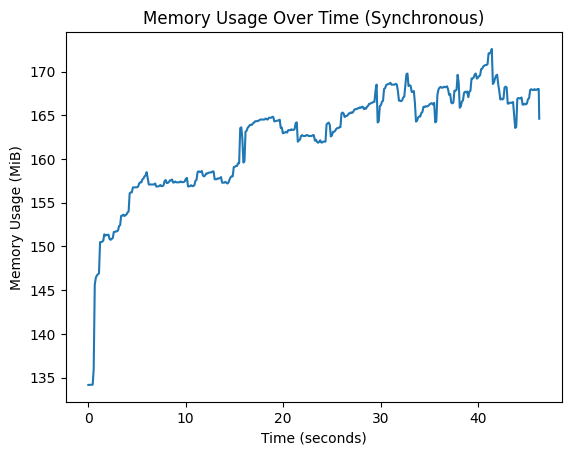

Maximum memory usage: 172.58203125 MiB


In [12]:
import matplotlib.pyplot as plt

# Plot with accurate time on the x-axis
plt.plot(relative_times, mem_usage)
plt.xlabel('Time (seconds)')
plt.ylabel('Memory Usage (MiB)')
plt.title('Memory Usage Over Time (Synchronous)')
plt.show()

# Or simply print the maximum memory usage
print(f"Maximum memory usage: {max(mem_usage)} MiB")

# Async

In [6]:
import pandas as pd
from memory_profiler import memory_usage
from concurrent.futures import ThreadPoolExecutor
from libs.utils.esquire.neighbors.logic_async import get_all_neighbors_async
import asyncio

In [7]:
def run_async_in_thread(async_func, *args, **kwargs):
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)
    try:
        return loop.run_until_complete(async_func(*args, **kwargs))
    finally:
        loop.close()


def profile_async_function(async_func, *args, **kwargs):
    with ThreadPoolExecutor(max_workers=1) as executor:
        # Submit the async function to run in a separate thread
        future = executor.submit(run_async_in_thread, async_func, *args, **kwargs)
        mem_usage_info_async, return_val = memory_usage(future.result, interval=0.1, timestamps=True, retval=True)
    return mem_usage_info_async, return_val

In [8]:
# Define a wrapper function to run the profiling
def run_get_all_neighbors():
    loop = asyncio.get_event_loop()
    return loop.run_until_complete((get_all_neighbors_async(df, 3)))
    

# Profile the memory usage
mem_usage_info_async, return_val_async = profile_async_function(
    get_all_neighbors_async, 
    address_df=df, 
    N=3, 
    same_side_only=True, 
    limit=-1
    )

# Extract memory usage and timestamps
mem_usage_async = [item[0] for item in mem_usage_info_async]
timestamps_async = [item[1] for item in mem_usage_info_async]

# Convert timestamps to seconds relative to the first timestamp
relative_times_async = [(t - timestamps_async[0]) for t in timestamps_async]


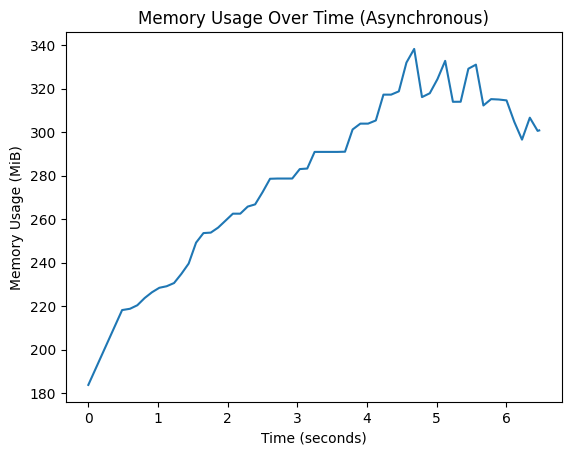

Maximum memory usage: 338.328125 MiB


In [13]:
import matplotlib.pyplot as plt

# Plot with accurate time on the x-axis
plt.plot(relative_times_async, mem_usage_async)
plt.xlabel('Time (seconds)')
plt.ylabel('Memory Usage (MiB)')
plt.title('Memory Usage Over Time (Asynchronous)')
plt.show()

# Or simply print the maximum memory usage
print(f"Maximum memory usage: {max(mem_usage_async)} MiB")

In [10]:
if return_val.compare(return_val_async).empty:
    print('Same results!')

Same results!


In [11]:
print(f'   Synchronous |   Asynchronous |  % Change')
print(' ' + '='*45)
print(f'{max(mem_usage):>10.2f} MiB | {max(mem_usage_async):>10.2f} MiB | {((max(mem_usage_async) - max(mem_usage)) / max(mem_usage)) * 100:>+7.2f} %')
print(f'{max(relative_times):>10.2f} s   | {max(relative_times_async):>10.2f} s   | {((max(relative_times_async) - max(relative_times)) / max(relative_times)) * 100:>+7.2f} %')


   Synchronous |   Asynchronous |  % Change
    172.58 MiB |     338.33 MiB |  +96.04 %
     46.30 s   |       6.47 s   |  -86.02 %
